In [ ]:
!pip install tifffile

Loaded image with shape: (1625, 1888, 4), dtype: uint16


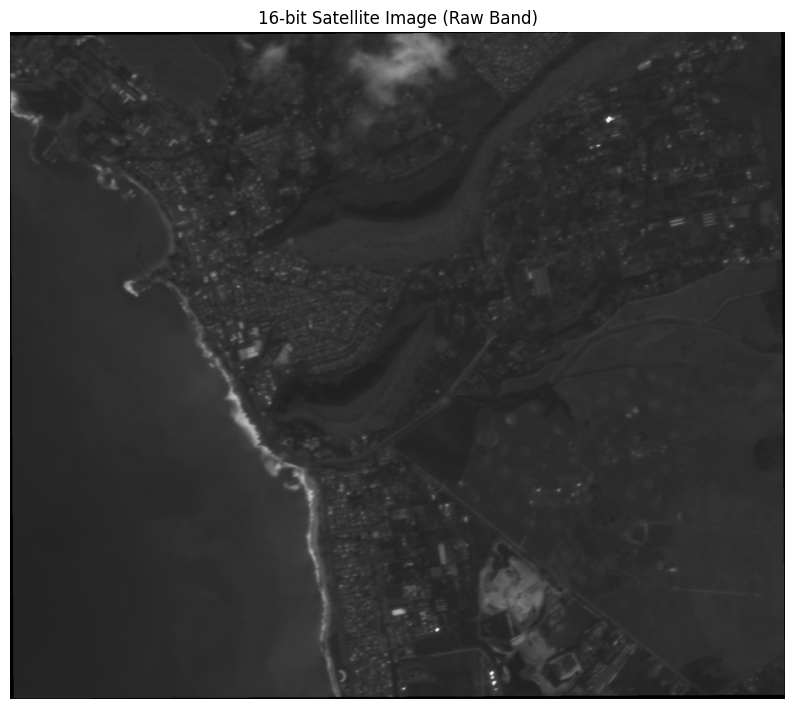

In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def show_16bit_tiff(tiff_path):
    # Load image (likely uint16)
    image_data = tifffile.imread(tiff_path)
    print(f"Loaded image with shape: {image_data.shape}, dtype: {image_data.dtype}")

    # If multi-band, show the first band (commonly Red or SAR)
    if image_data.ndim == 3:
        if image_data.shape[0] <= 10:  # likely [bands, H, W]
            image_data = np.transpose(image_data, (1, 2, 0))
        band_to_show = image_data[:, :, 0]
    else:
        band_to_show = image_data

    # Display using matplotlib (it handles scaling for display)
    plt.figure(figsize=(10, 10))
    plt.imshow(band_to_show, cmap='gray')
    plt.title("16-bit Satellite Image (Raw Band)")
    plt.axis("off")
    plt.show()

# Example usage
tiff_file_path = "/content/Clipped_try1.tif"
show_16bit_tiff(tiff_file_path)


Saved full normalized image as: /content/Clipped_try1_normalized.jpg
Image size: 1888 x 1625


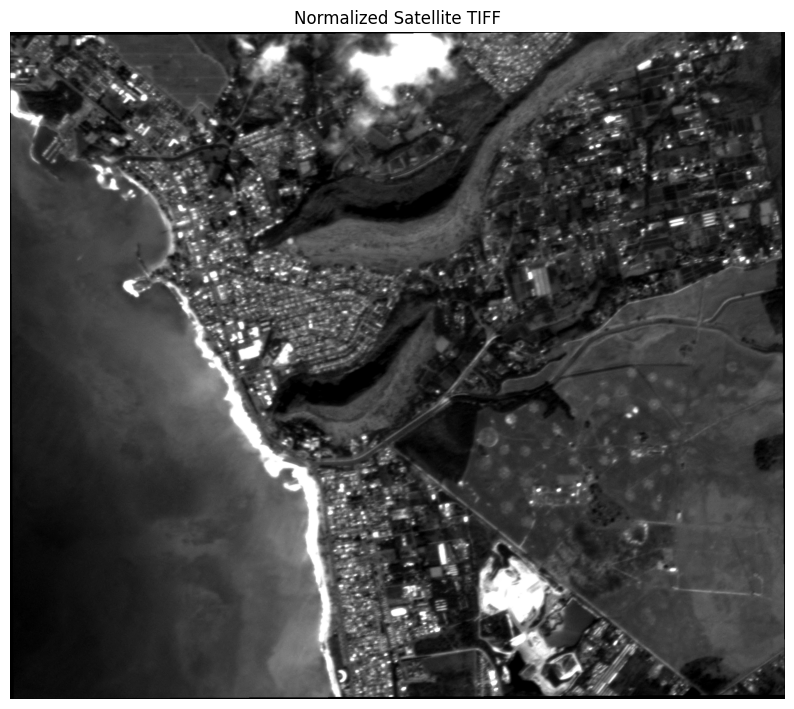

Saved 168 patches in 'patch_output'


In [3]:
import tifffile
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

def normalize_to_8bit(image_array):
    """Normalize a uint16 or float image array to 8-bit range (0–255)."""
    image_array = image_array.astype(np.float32)
    min_val = np.percentile(image_array, 2)
    max_val = np.percentile(image_array, 98)
    image_array = np.clip((image_array - min_val) / (max_val - min_val), 0, 1)
    return (image_array * 255).astype(np.uint8)

def split_tiff_to_jpg_patches(tiff_path, patch_size, output_dir):
    # Load satellite image
    image_data = tifffile.imread(tiff_path)

    # Handle multi-band or single-band
    if image_data.ndim == 3:
        if image_data.shape[0] <= 10:
            image_data = np.transpose(image_data, (1, 2, 0))
        image_gray = normalize_to_8bit(image_data[:, :, 0])
    elif image_data.ndim == 2:
        image_gray = normalize_to_8bit(image_data)
    else:
        raise ValueError("Unsupported image format")

    # Convert to PIL Image
    image = Image.fromarray(image_gray)

    # 🔸 Save full image as JPG outside patch folder
    full_jpg_path = os.path.splitext(tiff_path)[0] + "_normalized.jpg"
    image.save(full_jpg_path, "JPEG")
    print(f"Saved full normalized image as: {full_jpg_path}")

    width, height = image.size
    print(f"Image size: {width} x {height}")

    # Show the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.title("Normalized Satellite TIFF")
    plt.show()

    os.makedirs(output_dir, exist_ok=True)

    patch_id = 0
    for top in range(0, height, patch_size):
        for left in range(0, width, patch_size):
            right = min(left + patch_size, width)
            bottom = min(top + patch_size, height)

            if (right - left) == patch_size and (bottom - top) == patch_size:
                patch = image.crop((left, top, right, bottom))
                patch.save(os.path.join(output_dir, f"patch_{patch_id:04d}.jpg"), "JPEG")
                patch_id += 1

    print(f"Saved {patch_id} patches in '{output_dir}'")

# Example usage
tiff_file_path = "/content/Clipped_try1.tif"
patch_size_k = 128
output_directory = "patch_output"

split_tiff_to_jpg_patches(tiff_file_path, patch_size_k, output_directory)


In [ ]:
from PIL import Image
#If needed to mirror the image to match both input images
img = Image.open("/content/subset_0_of_S1A_IW_GRDH_1SDV_20241222T162412_20241222T162441_057107_07053F_848A_normalized.jpg")
img_h = img.transpose(Image.FLIP_LEFT_RIGHT)

img_h.show(title="Horizontal Flip")

In [ ]:
def encode_class_file(input_file):
    with open(input_file, 'r') as f:
        class_names = [line.strip() for line in f if line.strip()]

    unique_classes = list(set(class_names))
    class_to_number = {cls: idx for idx, cls in enumerate(unique_classes)}

    with open('mapping.txt', 'w') as f:
        for cls, idx in class_to_number.items():
            f.write(f"{cls}: {idx}\n")

    with open('class.txt', 'w') as f:
        for cls in class_names:
            f.write(f"{class_to_number[cls]}\n")

    print(f"Total lines processed: {len(class_names)}")

encode_class_file('LabelsGIS.txt')


Total lines processed: 168


#Train

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class PatchDataset(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(label_file, 'r') as f:
            self.labels = [int(line.strip()) for line in f]
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, efficientnet_b4
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, epochs=100):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return model


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = PatchDataset("patches_output", "class.txt", transform=transform)
train_size = int(0.8 * len(dataset))
train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

models = [efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, efficientnet_b4]
trained_models = []

for i, model_fn in enumerate(models):
    print(f"\nTraining EfficientNet-B{i}...")
    model = model_fn(weights="IMAGENET1K_V1")
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(set(dataset.labels)))  # Set correct output classes
    trained_model = train_model(model, train_loader, test_loader)
    trained_models.append(trained_model)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Training EfficientNet-B0...


100%|██████████| 20.5M/20.5M [00:00<00:00, 95.5MB/s]


Test Accuracy: 85.29%

Training EfficientNet-B1...


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 158MB/s]


Test Accuracy: 88.24%

Training EfficientNet-B2...


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 183MB/s]


Test Accuracy: 85.29%

Training EfficientNet-B3...


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 129MB/s]


Test Accuracy: 94.12%

Training EfficientNet-B4...


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 185MB/s]


Test Accuracy: 85.29%


In [ ]:
def visualize_activation(model, image_tensor, target_layer="features.5.0.conv.0"):
    model.eval()
    activations = []
    handle = None 
    for name, layer in model.named_modules():
        if name == target_layer:
            handle = layer.register_forward_hook(lambda module, input, output: activations.append(output.cpu().detach()))
            break

    if handle is None:
        raise ValueError(f"Target layer '{target_layer}' not found in the model. Please use a valid layer name.")

    with torch.no_grad():
        _ = model(image_tensor.unsqueeze(0).to(device))

    handle.remove()

    act = activations[0][0] 
    n_features = min(16, act.shape[0])  

    fig, axes = plt.subplots(1, n_features, figsize=(20, 5))
    for i in range(n_features):
        axes[i].imshow(act[i], cmap='viridis')
        axes[i].axis("off")
    plt.suptitle(f"Activation Maps from {target_layer}")
    plt.show()


In [ ]:
for name, _ in trained_models[0].named_modules():
    print(name)

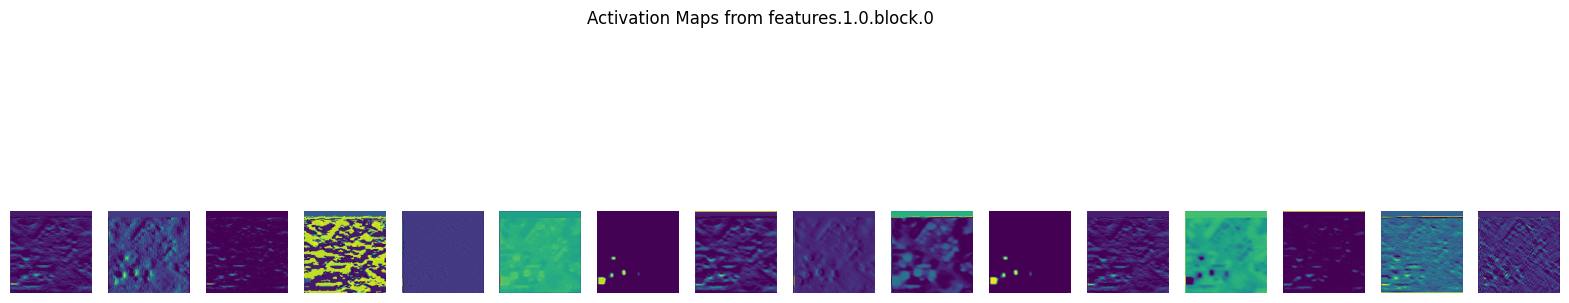

In [ ]:
sample_img, _ = dataset[0]
visualize_activation(trained_models[0], sample_img, target_layer="features.1.0.block.0")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    unique_labels_in_data = sorted(list(set(all_labels) | set(all_preds)))
    effective_class_names = [str(lbl) for lbl in unique_labels_in_data]


    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=effective_class_names, zero_division=0)) 

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=effective_class_names, yticklabels=effective_class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    acc = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return acc


Evaluating EfficientNet-B0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       0.80      0.80      0.80         5
           3       0.78      1.00      0.88        14
           4       1.00      0.25      0.40         4
           6       1.00      0.90      0.95        10

    accuracy                           0.85        34
   macro avg       0.92      0.79      0.80        34
weighted avg       0.88      0.85      0.83        34



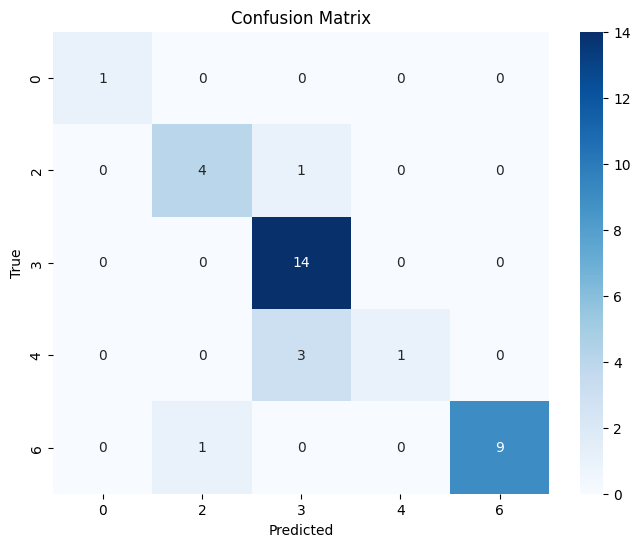


Evaluating B1

Classification Report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           2       0.67      0.80      0.73         5
           3       0.93      1.00      0.97        14
           4       1.00      0.75      0.86         4
           6       1.00      0.80      0.89        10

    accuracy                           0.88        34
   macro avg       0.82      0.87      0.82        34
weighted avg       0.91      0.88      0.89        34



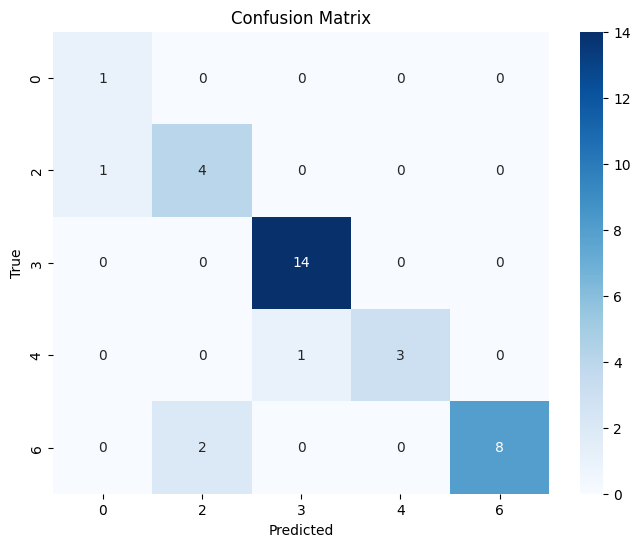


Evaluating B2

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       0.80      0.80      0.80         5
           3       0.82      1.00      0.90        14
           4       1.00      0.25      0.40         4
           6       0.90      0.90      0.90        10

    accuracy                           0.85        34
   macro avg       0.90      0.79      0.80        34
weighted avg       0.87      0.85      0.83        34



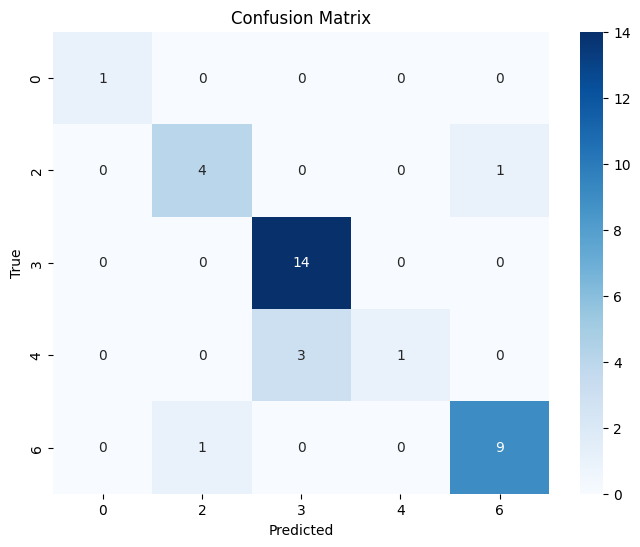


Evaluating B3

Classification Report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           2       1.00      0.80      0.89         5
           3       0.93      1.00      0.97        14
           4       1.00      0.75      0.86         4
           6       1.00      1.00      1.00        10

    accuracy                           0.94        34
   macro avg       0.89      0.91      0.88        34
weighted avg       0.96      0.94      0.94        34



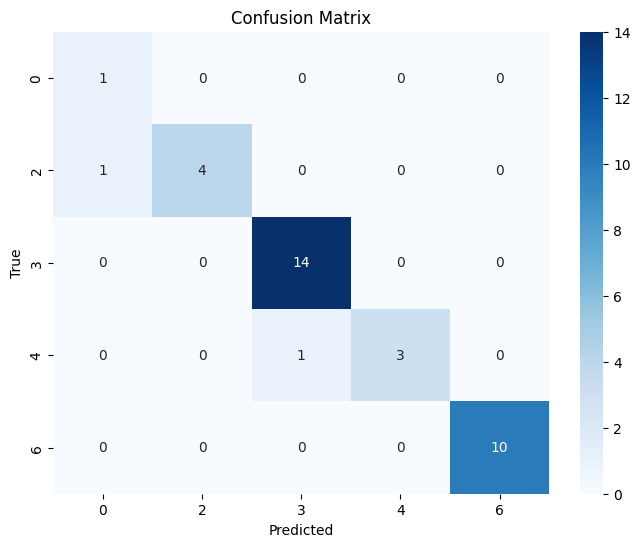


Evaluating B4

Classification Report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           2       0.80      0.80      0.80         5
           3       0.81      0.93      0.87        14
           4       1.00      0.25      0.40         4
           6       1.00      1.00      1.00        10

    accuracy                           0.85        34
   macro avg       0.82      0.80      0.75        34
weighted avg       0.88      0.85      0.84        34



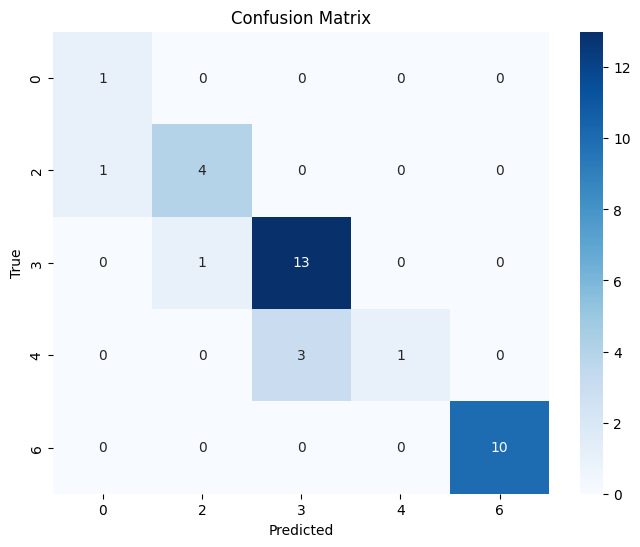

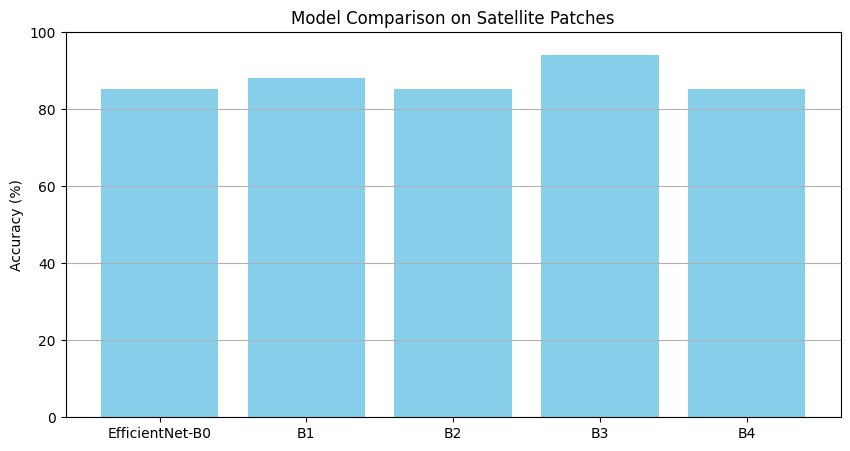

In [ ]:
model_names = ["EfficientNet-B0", "B1", "B2", "B3", "B4"]
accuracies = []

for i, model in enumerate(trained_models):
    print(f"\nEvaluating {model_names[i]}")
    acc = evaluate_model(model, test_loader, class_names = [str(j) for j in sorted(set(dataset.labels))]) 
    accuracies.append(acc)

plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color="skyblue")
plt.ylabel("Accuracy (%)")
plt.title("Model Comparison on Satellite Patches")
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()